# Return on Investment of Senators and Source of Campaign Contributions
### The Data Incubator project proposal

### Project Proposal
My project aims to calculate the return on investment that voters and political contributors get on their elected officials as measured by federal expenditures in their district. I want to track the “quid pro quo” that is exchanged between democratic participants and leaders. My goal is to do this at a resolution of individual candidates, congressional districts, and by sector (i.e., contributions/expenditures in health care, defense, energy, etc.). Anomalies is this analysis will identify, at best, extremely efficient congress people, and at worst, corrupt ones. 

In our democracy, individuals submit to taxation in return for the ability to choose their elected officials. For their vote, constituents expect that their representative will benefit their district, most obviously in the form of a slice of the federal budget. Also in our democracy, congressional districts are of equal size (“one person, one vote”). It naturally follows that, all things being equal, congressional districts should receive about the same in terms of financial expenditures from the federal government. 

However, egalitarian distribution of the federal budget is not the case. Why is this? I wish to look at two factors: 1) the influence that a district’s tax contributions have on its disbursement, and 2) the effect that campaign contributions to a candidate, both from inside and outside their district, have on the district’s disbursement. 

This project relies on three different datasets, which are relatively well curated but come from disparate sources. I will rely on the FEC and FollowTheMoney.org for campaign contribution data, USASpending.gov for federal expenditures, and the IRS for tax contribution. Additionally, datasets from usafacts.org may prove useful. 

While my line of reasoning is not unique, I cannot find this analysis publicly. I believe that the analysis will be valuable to both average citizens, businesses in particular sectors, and investors (https://www.researchgate.net/publication/46543239_Abnormal_Returns_from_the_Common_Stock_Investments_of_the_US_Senate). While my goal is to analyze the above transactions at the congressional district level, I will begin with data from the Senate candidates in 2016 as a proof of concept.

## Modules

In [16]:
import numpy as np
import scipy.stats as sps
import pandas as pd

# plotting
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'DejaVu Sans'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set axes and tick width
plt.rc('axes', linewidth=0.5)
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5

# Part 1: ROI on each tax dollar by state
* The return on investment (ROI) on each tax dollar is defined as the amount of dollars a state recieves from the federal goverment for each dollar it puts in. 
* We will use this quantity as a measure of how much the senators bring back to their state. 
* Data is from 2018. 

## Load small datasets
* Clean up numbers and names.

In [17]:
# fed awards
csv_filepath_fed_awards = './federal_expenditures_per_state_2018.csv'
fed_awards_df = pd.read_csv(csv_filepath_fed_awards, names=['state', 'state_short', 'fed_awards'])

for i, row in fed_awards_df.iterrows():
    row['state'] = row['state'][:-5]
    row['fed_awards'] = float(''.join(row['fed_awards'][1:].split(',')))
fed_awards_df = fed_awards_df.set_index('state')

# taxes
csv_filepath_state_taxes = './2018_tax_revenue_by_state_IRS.csv'
taxes_df = pd.read_csv(csv_filepath_state_taxes)
taxes_df.columns = ['state', 'tax_revenue']

for i, row in taxes_df.iterrows():
    row['tax_revenue'] = float(''.join(row['tax_revenue'].split(','))) * 1000
taxes_df = taxes_df.set_index('state')

# population
csv_filepath_pop = './census_populations.csv'
pop_df = pd.read_csv(csv_filepath_pop)

pop_df = pop_df[['Geographic Area', '2018']]
pop_df.columns = ['state', 'population']

for i, row in pop_df.iterrows():
    row['population'] = float(''.join(row['population'].split(',')))
    
pop_df = pop_df.set_index('state')


In [18]:
# just limit to the states (no DC or Puerto Rico, etc.)
states = list(pop_df.index.unique())
drop_names = ['United States',
 'Northeast',
 'Midwest',
 'South',
 'West',
 'District of Columbia',
 'Puerto Rico']

for name in drop_names:
    states.remove(name)
    
print('# of states = ', len(states))

fed_awards_df = fed_awards_df.loc[states]
taxes_df = taxes_df.loc[states]
pop_df = pop_df.loc[states]

print(len(fed_awards_df), len(taxes_df), len(pop_df))

# combine into one table
states_df = pd.merge(fed_awards_df, taxes_df, left_index=True, right_index=True)
states_df = pd.merge(states_df, pop_df, left_index=True, right_index=True)

# states_df[:10]

# of states =  50
50 50 50


In [19]:
# Calculate award and tax per capita, and ratio between the two
states_df['award_per_cap'] = states_df['fed_awards'] / states_df['population']
states_df['tax_per_cap'] = states_df['tax_revenue'] / states_df['population']
states_df['dollar_ROI'] = states_df['fed_awards'] / states_df['tax_revenue']

states_df = states_df.sort_values(by='dollar_ROI', ascending=True)

states_df[:10]

,state_short,fed_awards,tax_revenue,population,award_per_cap,tax_per_cap,dollar_ROI
state,,,,,,,
Delaware,DE,7.4905e+09,1.90387e+10,967171,7744.76,19684.9,0.393436
New Jersey,NJ,6.10236e+10,1.38977e+11,8.90852e+06,6850.03,15600.4,0.439092
Illinois,IL,7.76097e+10,1.61189e+11,1.27411e+07,6091.3,12651.1,0.481482
Massachusetts,MA,6.50818e+10,1.17998e+11,6.90215e+06,9429.21,17095.9,0.551548
Ohio,OH,7.78806e+10,1.40891e+11,1.16894e+07,6662.48,12052.9,0.552771
Nebraska,NE,1.50162e+10,2.53123e+10,1.92927e+06,7783.38,13120.2,0.593238
New York,NY,1.70804e+11,2.8122e+11,1.95422e+07,8740.25,14390.4,0.607366
Washington,WA,5.58299e+10,9.04041e+10,7.53559e+06,7408.83,11996.9,0.617559
California,CA,2.82203e+11,4.56556e+11,3.9557e+07,7134.08,11541.7,0.618113


# Plot 1: ROI of each tax dollar by state in 2018
* The return on investment (ROI) on each tax dollar is defined as the amount of dollars a state recieves from the federal goverment for each dollar it puts in. 
* In the bar chart below, states are ordered from highest ROI to lowest. 

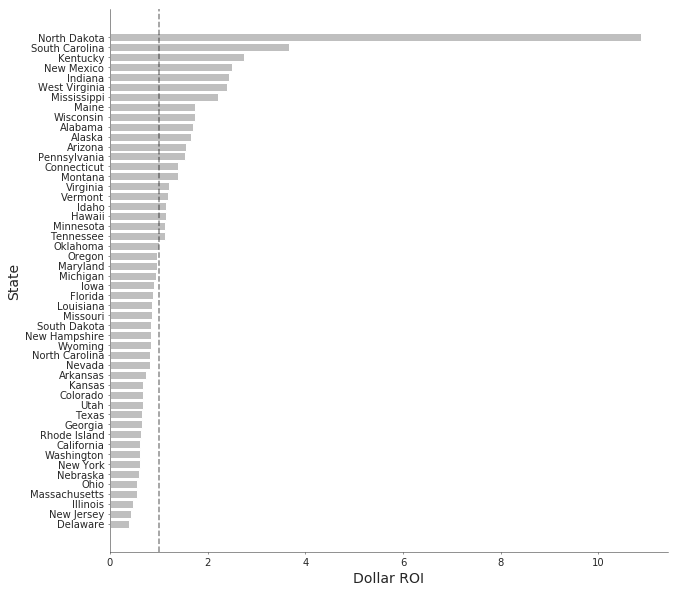

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.barh(y=range(len(states_df)), width=states_df['dollar_ROI'], 
        color='0.75')

ax.axvline(1, color='k', alpha=0.5, ls='--')

ax.set_yticks(range(50))
ax.set_yticklabels(states_df.index)

ax.set_ylabel('State', fontsize=BIGGER_SIZE)
ax.set_xlabel('Dollar ROI', fontsize=BIGGER_SIZE)

sns.despine()

plt.show()

# Part 2: Source of contribution to Senators in 2016
* For Senators who won their races in 2016, find fraction of contributions that came from within and outside of the states. 
* Most contributions go through PACs or other comitees, so as a first approximation we will take the location of the commitee as the donation source. Future analysis should also look at where the commitees recieve their money. 
* This initial analysis also does not consider money spent on the candidates by the parties themselves. 

In [21]:
# Load dataset with senators, their race status, and their candidate ID
csv_filepath_senators = './senate_2016_candidates_edit.csv'
senators_df = pd.read_csv(csv_filepath_senators)
# print(senators_df.columns)
senators_df = senators_df[senators_df['won'] == 1]
senators_df = senators_df[['name', 'state', 'candidate_id']]
# add columns for data to be calculated
senators_df['instate_donations'] = 0.0
senators_df['outstate_donations'] = 0.0
senators_df['state_dollar_ROI'] = 0.0

In [22]:
#senators_df[:5]

In [23]:
# Load data saying which commitees contributed to which candidates
csv_filepath_committee_contributions = './2016_contributions_to_candidates.txt'
committee_header = ['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI','IMAGE_NUM',
                    'TRANSACTION_TP','ENTITY_TP','NAME','CITY','STATE','ZIP_CODE',
                    'EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT',
                    'OTHER_ID','CAND_ID','TRAN_ID','FILE_NUM','MEMO_CD','MEMO_TEXT','SUB_ID']
committee_df = pd.read_csv(csv_filepath_committee_contributions, sep='|', names=committee_header)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,11,12,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
committee_df = committee_df[['CMTE_ID','NAME','CITY','STATE','ZIP_CODE',
                             'TRANSACTION_AMT','CAND_ID',]]

In [25]:
committee_df[:5]

,CMTE_ID,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_AMT,CAND_ID
0,C00548198,BLAINE FOR CONGRESS,JEFFERSON CITY,MO,65102,2500,H8MO09153
1,C00548198,KEVIN MCCARTHY FOR CONGRESS,BAKERSFIELD,CA,93389,1000,H6CA22125
2,C00235739,DAN NEWHOUSE FOR CONGRESS,YAKIMA,WA,98909,2500,H4WA04104
3,C00235739,CATHY MCMORRIS RODGERS FOR CONGRESS,SPOKANE,WA,99210,1000,H4WA05077
4,C00235739,MANCHIN FOR WEST VIRGINIA,WASHINGTON,DC,20002,1000,S0WV00090


Determine the fraction of donations coming from commitees inside a candidates states versus outside. 

In [26]:
for i, row in senators_df.iterrows():
#     print(i)
    state_temp = row['state']
    cand_id_temp = row['candidate_id']

    commitee_instate_temp_df = committee_df[(committee_df['CAND_ID'] == cand_id_temp) & 
                                    (committee_df['STATE'] == state_temp)]
    senators_df.at[i,'instate_donations'] = commitee_instate_temp_df['TRANSACTION_AMT'].sum()
#     df.at[i,'ifor'] = ifor_val

    commitee_outstate_temp_df = committee_df[(committee_df['CAND_ID'] == cand_id_temp) & 
                                    (committee_df['STATE'] != state_temp)]
    senators_df.at[i, 'outstate_donations'] = commitee_outstate_temp_df['TRANSACTION_AMT'].sum()
    
    dollar_roi_temp = states_df[states_df['state_short'] == state_temp]['dollar_ROI']
    senators_df.at[i, 'state_dollar_ROI'] = float(dollar_roi_temp)
    

In [27]:
senators_df['commitee_donations_total'] = senators_df['instate_donations'] + senators_df['outstate_donations']
senators_df['donation_ratio'] = senators_df['instate_donations'] / senators_df['outstate_donations']

senators_df = senators_df.sort_values(by='donation_ratio', ascending=True)

senators_df = senators_df.dropna(how='any')

In [28]:
senators_df[:5]

,name,state,candidate_id,instate_donations,outstate_donations,state_dollar_ROI,commitee_donations_total,donation_ratio
187,"MCCAIN, JOHN S",AZ,S6AZ00019,64473.0,4645957.0,1.558116,4710430.0,0.013877
112,"TOOMEY, PATRICK JOSEPH",PA,S4PA00121,1610622.0,71739375.0,1.542713,73349997.0,0.022451
179,"HASSAN, MARGARET WOOD",NH,S6NH00091,1332771.0,41406229.0,0.844570,42739000.0,0.032188
223,"MASTO, CATHERINE CORTEZ",NV,S6NV00200,1514361.0,44733210.0,0.813822,46247571.0,0.033853
93,"BURR, RICHARD M",NC,S4NC00089,4214518.0,41028047.0,0.814788,45242565.0,0.102723


# Plot 2: Donation ratio by Senator in 2016
* The donation ratio is defined as the amount of money a Senator recieves from inside the state compared to outside the states. A value of 1 means they drew money evenly between in and out of state, higher values mean they got more money from in state. 
* Also add the Dollar ROI from the first plot to the corresponding state. 

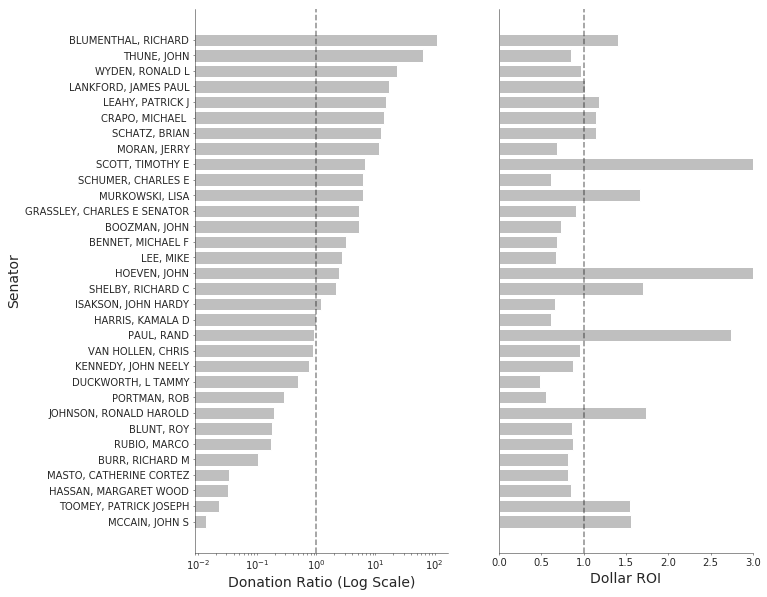

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].barh(y=range(len(senators_df)), width=senators_df['donation_ratio'], 
        color='0.75')

ax[0].set_xscale('log')

ax[0].axvline(1, color='k', alpha=0.5, ls='--')

ax[0].set_yticks(range(len(senators_df)))
ax[0].set_yticklabels(senators_df['name'])
ax[0].set_ylabel('Senator', fontsize=BIGGER_SIZE)
ax[0].set_xlabel('Donation Ratio (Log Scale)', fontsize=BIGGER_SIZE)

# dollar ROI
ax[1].barh(y=range(len(senators_df)), width=senators_df['state_dollar_ROI'], 
        color='0.75')

ax[1].axvline(1, color='k', alpha=0.5, ls='--')

ax[1].set_xlim(0, 3)

ax[1].get_yaxis().set_ticks([])
# ax[0].set_ylabel('Senator', fontsize=BIGGER_SIZE)
ax[1].set_xlabel('Dollar ROI', fontsize=BIGGER_SIZE)

sns.despine()

plt.show()

# Regression between Donation Ratio and Dollar ROI
* Doesn't seem to be any correlation between the two. 

Slope = 0.09032107719800149, y intercept = 1.4156842664378069, rvalue = 0.04979596917498004.


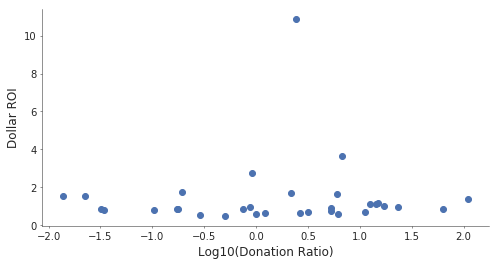

In [30]:
# compute fit and regression line. 
slope, intercept, rvalue, _, _ = sps.linregress(np.log10(senators_df['donation_ratio']),
                                           senators_df['state_dollar_ROI'])

print('Slope = {}, y intercept = {}, rvalue = {}.'.format(slope, intercept, rvalue))

# x_prediction = np.arange(2010, 2020, 1)
# y_prediction = x_prediction * slope + intercept

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.scatter(np.log10(senators_df['donation_ratio']), 
           senators_df['state_dollar_ROI'])
# ax.plot(x_prediction, y_prediction)

ax.set_xlabel('Log10(Donation Ratio)')
ax.set_ylabel('Dollar ROI')

# ax.set_xticks(x_prediction)

# ax.set_xlim(2009.5, 2019.5)
# ax.set_ylim(25000, 60000)

sns.despine()

plt.show()